# Track ESA's Cluster-II Spacecrafts with Your Groundstation
Use this notebook as a template to determine the link budget to track the Cluster-II satellites (https://sci.esa.int/web/cluster). The Cluster mission is composed of four satellites, CLUSTER FM5 to FM8. This notebook focuses on tracking of FM5.

In [ ]:
# Additional dependencies to install for this notebook:
!pip install pyyaml
!pip install matplotlib
!pip install skyfield

In [2]:
import yaml
import linkpredict as lp

In [3]:
# read configuration file
with open('example6.yaml', 'r') as f:
    config = yaml.safe_load(f)

### Your inputs

In [4]:
# Groundstation Receiver
lna = lp.Device(gain=20.0)
line_losses = lp.Device(gain=-1.0)
receiver = lp.Receiver.from_noise_figure(
    noise_figure=2.0, devices=[lna, line_losses])
rx_antenna = lp.MainLobeAntenna(peak_gain=17.5, beam_3db_width=18)
rx_antenna_noise = lp.SimpleAntennaNoise(300)

# Groundstation Location
GS_LAT = -29.045155  # deg
GS_LON = 115.354298  # deg
GS_ALT = 245  # m

# Satellite to track
CAT_NUMBER = 26463  # FM5

### Define Link budget

In [5]:
# Satellite Transmitter
transmitter = lp.Transmitter(
    amplifier_power=3.7,  # [dBW]
    devices=[lp.Device(gain=-2.7)])  # [dBW]
transmit_antenna = lp.MeasuredAntenna(
    measured_gains=config['CLUSTER_ANTENNA_GAIN'],
    linear_polarized=False, symetric=True)

# Path
from skyfield.positionlib import ICRF
class MyGeometry(lp.GroundstationSatelliteGeometry):
    def get_tx_antenna_angle(self, time):
        sat_antenna = ICRF([0, -0.397789, 0.917477])
        vector = self.get_range_vector(time)
        return vector.separation_from(sat_antenna).degrees
geometry = MyGeometry(GS_LAT, GS_LON, GS_ALT, cat_number=CAT_NUMBER)

# Channel
modulation = lp.DigitalModulation(
    symbol_rate=50116.14365, esno_ratio_threshold=0.5, modulation_loss=3.87)
channel = lp.Channel(frequency=2.256e+9, modulation=modulation)

# Link
link = lp.Link(
    channel=channel,
    geometry=geometry,
    transmitter=transmitter,
    transmit_antenna=transmit_antenna,
    receive_antenna=rx_antenna,
    receive_antenna_noise=rx_antenna_noise,
    receiver=receiver)

### Display visibilities for the next days

In [6]:
from datetime import datetime, timedelta
from skyfield.api import load, utc
ts = load.timescale()

deg = 5.0  # minimum elevation above horizon

t_start = datetime.utcnow()
t_end = t_start + timedelta(days=7)

t0 = ts.from_datetime(t_start.replace(tzinfo=utc))
t1 = ts.from_datetime(t_end.replace(tzinfo=utc))

t, events = geometry.satellite.find_events(geometry.groundstation, t0, t1, altitude_degrees=deg)
for ti, event in zip(t, events):
    name = ('AOS', 'culminate', 'LOS')[event]
    print(ti.utc_strftime('%Y %b %d %H:%M:%S'), name)

2021 Jan 20 12:59:15 AOS
2021 Jan 20 14:54:45 culminate
2021 Jan 20 17:53:36 LOS
2021 Jan 21 02:26:14 AOS
2021 Jan 21 07:21:15 culminate
2021 Jan 21 12:11:41 LOS
2021 Jan 22 01:03:17 AOS
2021 Jan 22 04:21:11 culminate
2021 Jan 22 07:30:50 LOS
2021 Jan 22 17:11:24 AOS
2021 Jan 22 19:05:25 culminate
2021 Jan 22 21:13:25 LOS
2021 Jan 23 03:11:49 AOS
2021 Jan 23 08:05:46 culminate
2021 Jan 23 13:01:33 LOS
2021 Jan 24 01:14:13 AOS
2021 Jan 24 05:12:18 culminate
2021 Jan 24 09:04:38 LOS
2021 Jan 24 21:10:46 AOS
2021 Jan 24 22:46:43 culminate
2021 Jan 25 00:07:56 LOS
2021 Jan 25 05:21:28 AOS
2021 Jan 25 09:22:36 culminate
2021 Jan 25 14:02:42 LOS
2021 Jan 26 01:24:13 AOS
2021 Jan 26 05:49:45 culminate
2021 Jan 26 10:10:28 LOS
2021 Jan 26 23:38:07 AOS
2021 Jan 27 01:07:59 culminate
2021 Jan 27 02:29:29 LOS


### Run calculation

In [7]:
%%time
from datetime import datetime, timedelta

t_start = datetime(2021, 1, 20, 13, 0)
t_end = datetime(2021, 1, 20, 18, 0)

time_step = timedelta(seconds=60)
result = link.calculate_link_budget(t_start, t_end, time_step)

time = t_start
elevation = []
while time <= t_end:
    elevation.append(geometry.get_elevation(time))
    time += time_step

CPU times: user 1.06 s, sys: 517 ms, total: 1.57 s
Wall time: 411 ms


### Visualize link budget

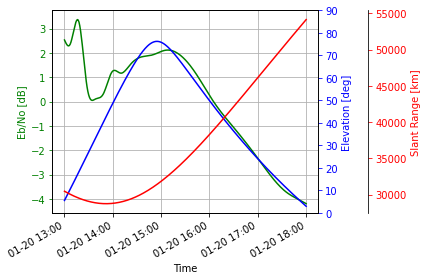

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

k = lp.LinkBudgetKeys
time = [n[k.time] for n in result]
ebno = [n[k.ebno_ratio] for n in result]
ebno_threshold = [n[k.ebno_ratio_threshold] for n in result]
slant_range = [n[k.slant_range]/1000 for n in result]

fig, ax1 = plt.subplots()
ax2, ax3, = ax1.twinx(), ax1.twinx()

ax1.plot(time, ebno, color='g')
ax1.plot(time, ebno_threshold, "y--")
ax1.tick_params('y', colors='g')
ax1.set_ylabel("Eb/No [dB]", color="g")

ax2.plot(time, elevation, color='b')
ax2.tick_params('y', colors='b')
ax2.set_ylabel("Elevation [deg]", color="b")
ax2.set_ylim(0, 90)

ax3.plot(time, slant_range, color='r')
ax3.tick_params('y', colors='r')
ax3.set_ylabel("Slant Range [km]", color="r")
ax3.spines["right"].set_position(("outward", 50))

ax1.set_xlabel("Time")
ax1.grid(True)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
fig.autofmt_xdate()
fig.tight_layout()
plt.show()